# Checking if there is a need to rotate the winds in the machine learnt model compared with the Norkyst model

**Conclusion:**

There is no a need to rotate the winds in the machine learning model. There are some differences between the wind components between the two models in speed, but the direction of the winds corresponds well. 

**The notebook consists of:**

- Plots to visualize differences in the wind components between the Norkyst 800 model and the Arome Meps 2_5km by:
    - Vector field plots
    - Colormesh plots with speed
- Plots visualizing the wind vectors of both models to compare direction. 

**Variable names**
- Truth is the Norkyst 800
- Machine learnt model is the Arome Meps 2_5km

In [1]:
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np
import scipy as sp

In [ ]:
#Read in files from the 1st of May 2023

ideal_file_path = f'/lustre/storeB/project/fou/hi/roms_hindcast/norkyst_v3/sdepth'
interp_file_path = f'/lustre/storeB/project/fou/hi/foccus/datasets/norkystv3_hindcast_atm_forcing/interpolated'

ds_ideal_2023 = xr.open_dataset(f'{ideal_file_path}/2023/05/norkyst800-20230501.nc').isel(time = 0, s_rho = -1)
interp_2023_u = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Uwind.nc').isel(time=0)
interp_2023_v = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Vwind.nc').isel(time=0)

In [3]:
#interp_2023_u.head()

In [9]:
#Select out u and v winds from the ideal dataset (truth dataset)
ds_ideal_u_2023 = ds_ideal_2023["Uwind_eastward"]
ds_ideal_v_2023 = ds_ideal_2023["Vwind_northward"]

In [4]:
#Rotating the winds for the interp forcings files
def rotate_vectorfield(U,V,alpha):
    '''rotate wind vectors clockwise. alpha may be a scalar or an array
    alpha is in degrees
    returns u,v '''
    alpha = np.array(alpha)*np.pi/180
    alpha = alpha.flatten()
    R = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)] ])
    shpe = U.shape
    origwind = np.array((U.flatten(), V.flatten()))
    if len(R.shape)==2:
        rotwind = dot(R, origwind) # for constant rotation angle
    else:
        # for rotation angle given as array with same dimensions as U and V:
        # k-loop with rotwind(k) = dot(R(i,j,k), origwind(j,k)) (einstein summation indices)
        rotwind = np.einsum("ijk,ik -> jk", R, origwind)  # einstein summation indices
    Urot, Vrot = rotwind[0,:], rotwind[1,:]
    Urot = Urot.reshape(shpe)
    Vrot = Vrot.reshape(shpe)
    return Urot, Vrot

In [5]:
urot, vrot = rotate_vectorfield(interp_2023_u["Uwind"].values, interp_2023_v["Vwind"].values, interp_2023_u["lat"].values)

In [ ]:
#Checking if it works
#urot
#vrot

Text(0.5, 1.0, 'After rotation')

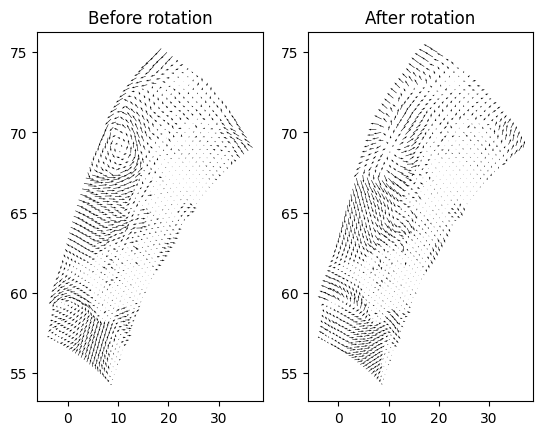

In [10]:
#Quiver plots to compare the wind vectors before and after rotation of Arome meps
s  = 50
fig, ax = plt.subplots(1,2)
ax[0].quiver(interp_2023_u["lon"].values[::s,::s], interp_2023_u["lat"].values[::s,::s], interp_2023_u["Uwind"].values[::s,::s], interp_2023_v["Vwind"].values[::s,::s])
ax[1].quiver(interp_2023_u["lon"].values[::s,::s], interp_2023_u["lat"].values[::s,::s],urot[::s,::s], vrot[::s,::s])
ax[0].set_title("Before rotation")
ax[1].set_title("After rotation")

/tmp/ipykernel_2377623/3155405999.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("turbo")


Text(0.5, 1.0, 'Rotated Arome Meps - vwind')

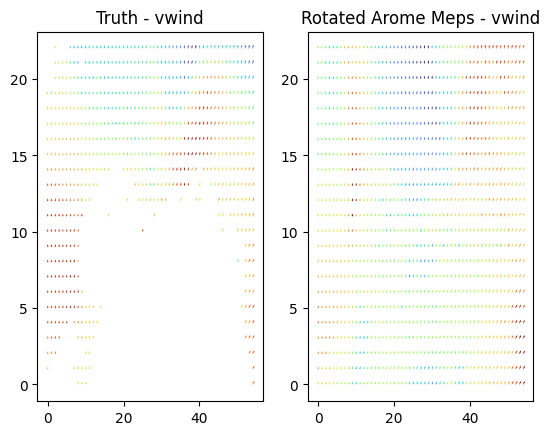

In [11]:
#Comparing the vector fields of Norkyst and arome meps after rotation for the v_winds
s  = 50
fig, ax = plt.subplots(1,2)
cmap = mpl.cm.get_cmap("turbo")
ax[0].quiver(ds_ideal_u_2023["lon"].values[::s,::s], ds_ideal_u_2023["lat"].values[::s,::s], ds_ideal_v_2023.values[::s,::s], cmap = cmap)
ax[1].quiver(interp_2023_u["lon"].values[::s,::s], interp_2023_u["lat"].values[::s,::s],vrot[::s,::s], cmap = cmap)
ax[0].set_title("Truth - vwind")
ax[1].set_title("Rotated Arome Meps - vwind")

/tmp/ipykernel_2377623/1093710941.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("turbo")


Text(0.5, 1.0, 'Rotated Arome Meps - uwind')

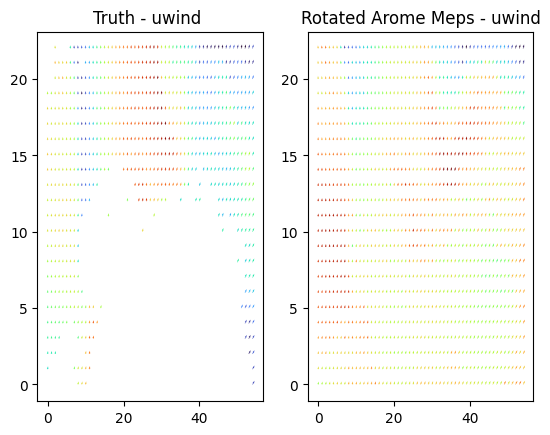

In [12]:
#Repeat for u
s  = 50
fig, ax = plt.subplots(1,2)
cmap = mpl.cm.get_cmap("turbo")
ax[0].quiver(ds_ideal_u_2023["lon"].values[::s,::s], ds_ideal_u_2023["lat"].values[::s,::s], ds_ideal_u_2023.values[::s,::s], cmap = cmap)
ax[1].quiver(interp_2023_u["lon"].values[::s,::s], interp_2023_u["lat"].values[::s,::s],urot[::s,::s], cmap = cmap)
ax[0].set_title("Truth - uwind ")
ax[1].set_title("Rotated Arome Meps - uwind")

We see that after rotating the u and v winds for the arome meps dataset, the vector fields are not the same. 

I will therefore plot the speed differences for uwind, vwind and their absolute value. 

In [13]:
#Function for plotting the speed
def plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle, **kwargs):
    fig,ax = plt.subplots(3, figsize = (8,14))

    #Colormap colors
    cmap = plt.cm.GnBu
    norm1 = mpl.colors.Normalize(vmin=-15,vmax=20) 
    #norm2 = mpl.colors.Normalize(vmin=-10,vmax=10) #small values in the last plot to be able to easily spot the difference when comparing plots 

    #Image 1
    image1 = ax[0].pcolormesh(variable_1, shading = "auto", cmap=cmap, norm = norm1) #, norm = norm1)
    ax[0].set_title(title_1)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    #Image 2
    image2 = ax[1].pcolormesh(variable_2, shading = "auto", cmap = cmap, norm = norm1)#, norm = norm1)
    ax[1].set_title(title_2)
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")

    #Image 3 - comparing the data. Value 2 - value 1. 
    image3 = ax[2].pcolormesh(variable_2 - variable_1, **kwargs)#, norm = norm2)
    #image3 = ax[2].quiver(x,y,variable_2 - variable_1, scale=1, color = "black")
    ax[2].set_title(title_3)
    ax[2].set_xlabel("x")
    ax[2].set_ylabel("y")
    plt.suptitle(suptitle)
    plt.tight_layout()

    
    fig.colorbar(image1, cmap=cmap, ax=ax[0], label = f'{variable_1_name}')
    fig.colorbar(image2, cmap=cmap, ax=ax[1], label = f'{variable_2_name}')
    fig.colorbar(image3, cmap=cmap, ax=ax[2], label = f'Comparison of: {variable_2_name} - {variable_1_name}')
    return plotting_output_compare

Text(0, 0.5, 'y')

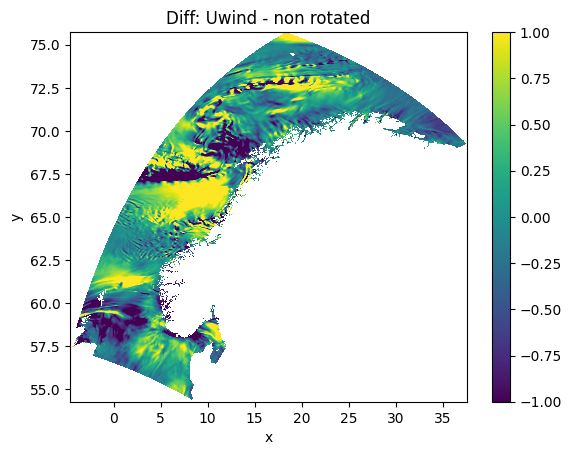

In [17]:
#Difference plot. Truth model - Arome Meps for uwind non rotated.
plt.pcolormesh(ds_ideal_u_2023.lon, ds_ideal_u_2023.lat, (ds_ideal_u_2023.values - interp_2023_u["Uwind"]), vmin=-1, vmax=1)
plt.colorbar()
plt.title(f'Diff: Uwind - non rotated') 
plt.xlabel('x')
plt.ylabel('y')

Text(0.5, 1.0, 'Diff: Vwind - non rotated')

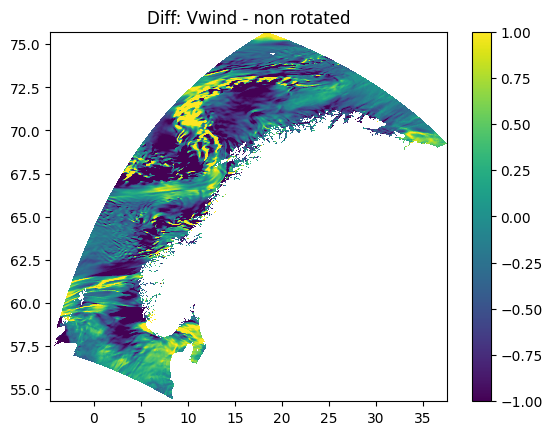

In [18]:
#Repeat for vwinds
plt.pcolormesh(ds_ideal_v_2023.lon, ds_ideal_v_2023.lat, (ds_ideal_v_2023.values - interp_2023_v["Vwind"]), vmin=-1, vmax=1)
plt.colorbar()
plt.title(f'Diff: Vwind - non rotated')

<function __main__.plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle, **kwargs)>

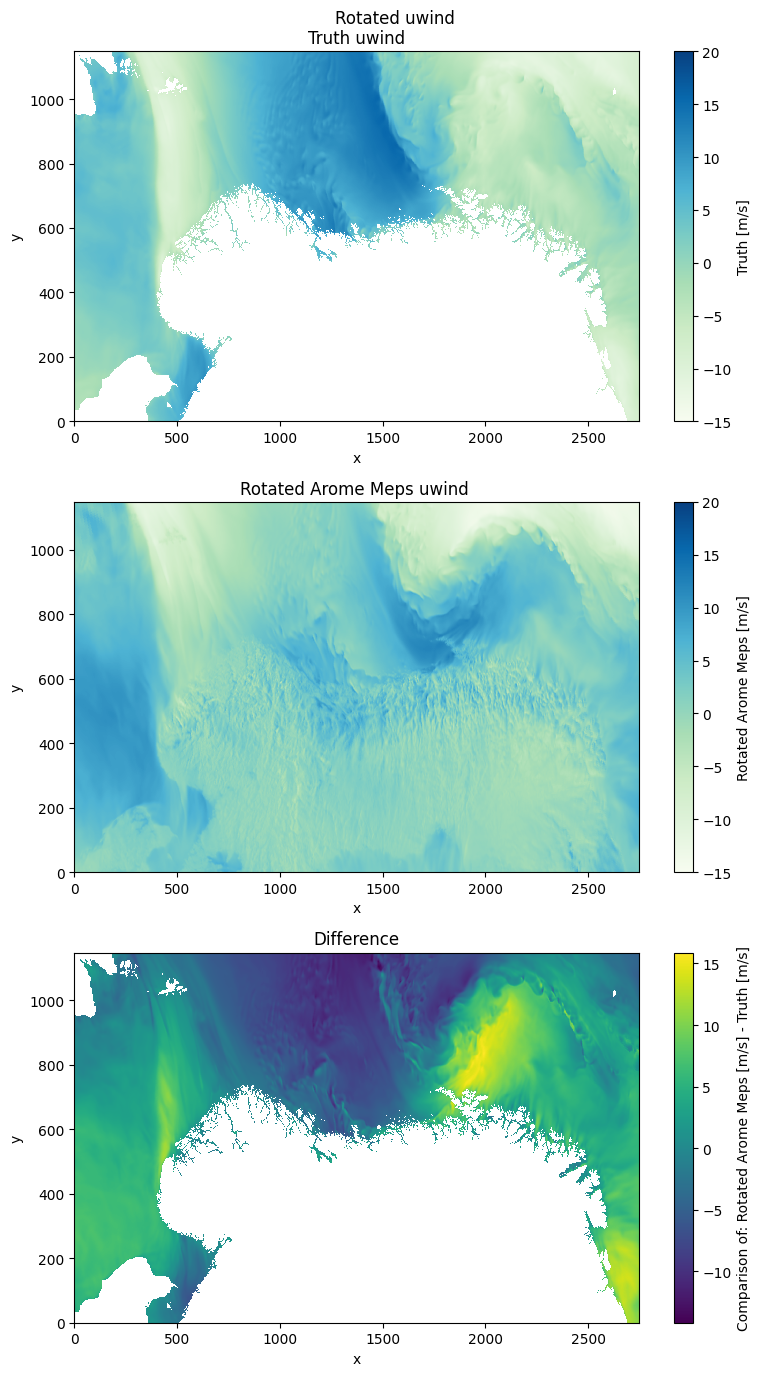

In [22]:
plotting_output_compare(variable_1=ds_ideal_u_2023, variable_2=urot, title_1="Truth uwind", title_2="Rotated Arome Meps uwind ", title_3="Difference", suptitle="Rotated uwind", variable_1_name="Truth [m/s]", variable_2_name="Rotated Arome Meps [m/s]")

In [23]:
diff = ds_ideal_u_2023.values - interp_2023_u["Uwind"].values
np.printoptions(np.inf)
#print(diff)

In [24]:
diff2 = ds_ideal_u_2023.values - urot
#print(diff2)

In [25]:
#Make sure both models has the same time values
ds_ideal_u_2023.time.values
interp_2023_u.time.values
#They do - so different times are not the problem.

np.datetime64('2023-05-01T00:00:00.000000000')

<function __main__.plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle, **kwargs)>

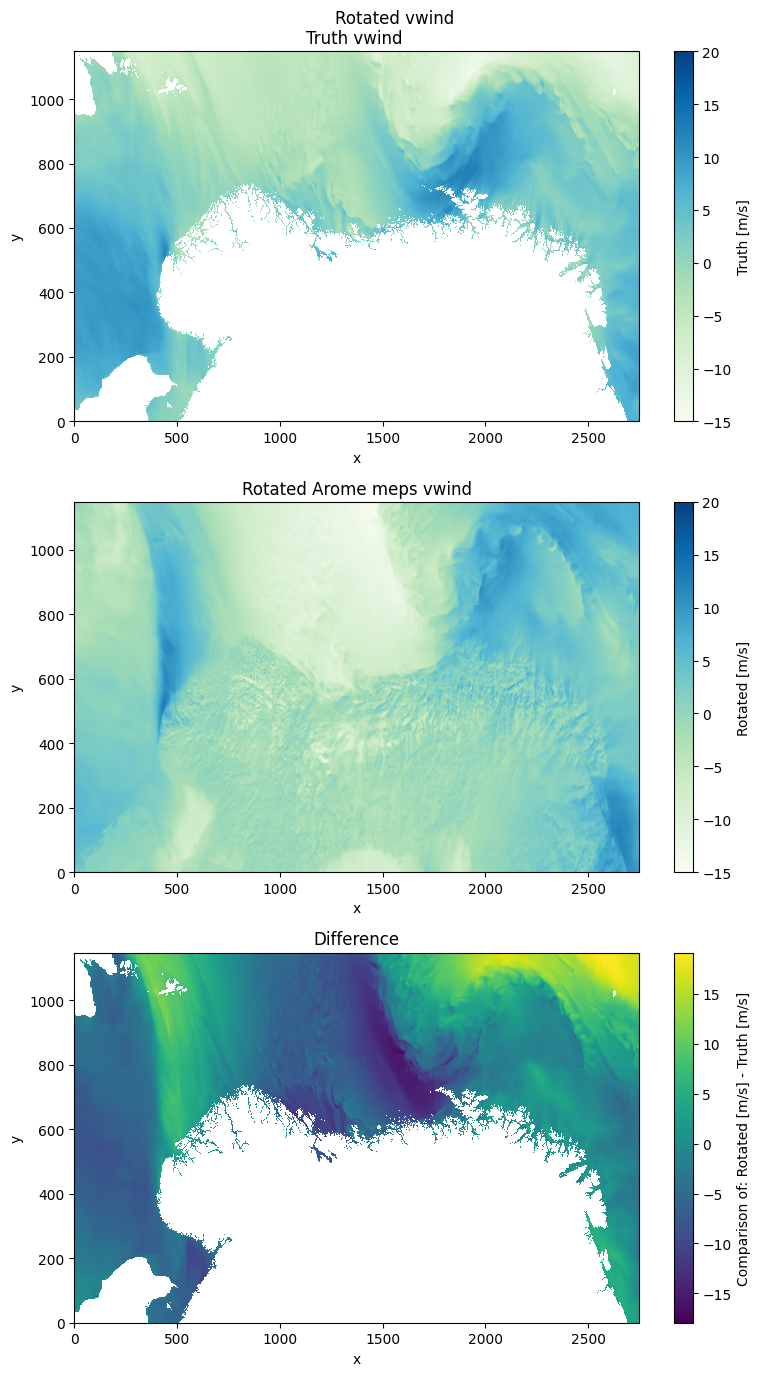

In [26]:
plotting_output_compare(variable_1=ds_ideal_v_2023, variable_2=vrot, title_1="Truth vwind ", title_2="Rotated Arome meps vwind", title_3="Difference", suptitle="Rotated vwind", variable_1_name="Truth [m/s]", variable_2_name="Rotated [m/s]")


**Results so far:**

The difference between the winds in the Norkyst model and the Arome Meps model seem to increase when the Arome Meps winds are rotated. 

I will now compare using the absolute values of v and u winds. 

In [50]:
import cartopy
import cmocean
import cartopy.crs as ccrs


In [31]:
abs_val_ideal = np.sqrt(ds_ideal_u_2023.values**2 + ds_ideal_v_2023.values**2)
abs_val_interp = np.sqrt(interp_2023_u["Uwind"].values**2 + interp_2023_v["Vwind"].values**2)

<function __main__.plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle, **kwargs)>

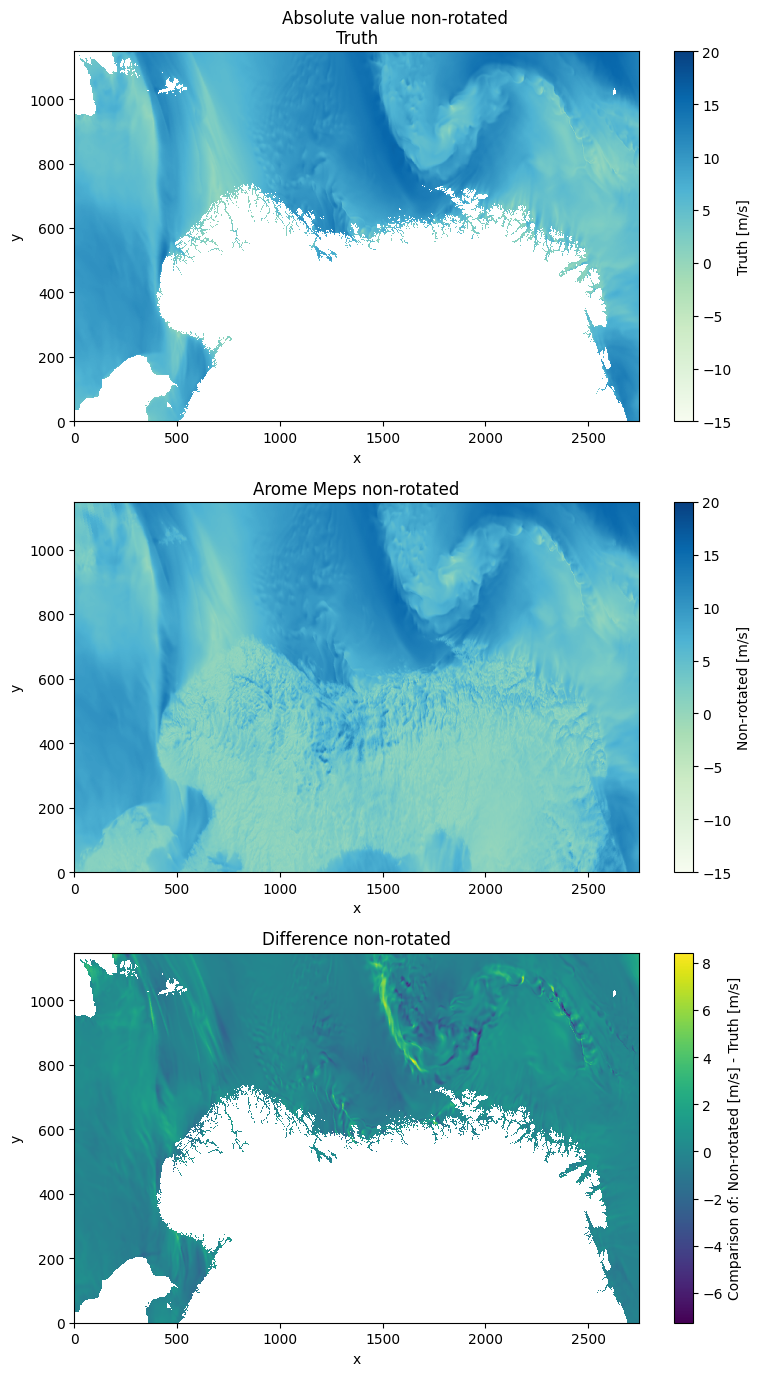

In [35]:
plotting_output_compare(variable_1=abs_val_ideal, variable_2=abs_val_interp, title_1="Truth", title_2="Arome Meps non-rotated", title_3="Difference non-rotated", suptitle="Absolute value non-rotated", variable_1_name="Truth [m/s]", variable_2_name="Non-rotated [m/s]")

<function __main__.plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle, **kwargs)>

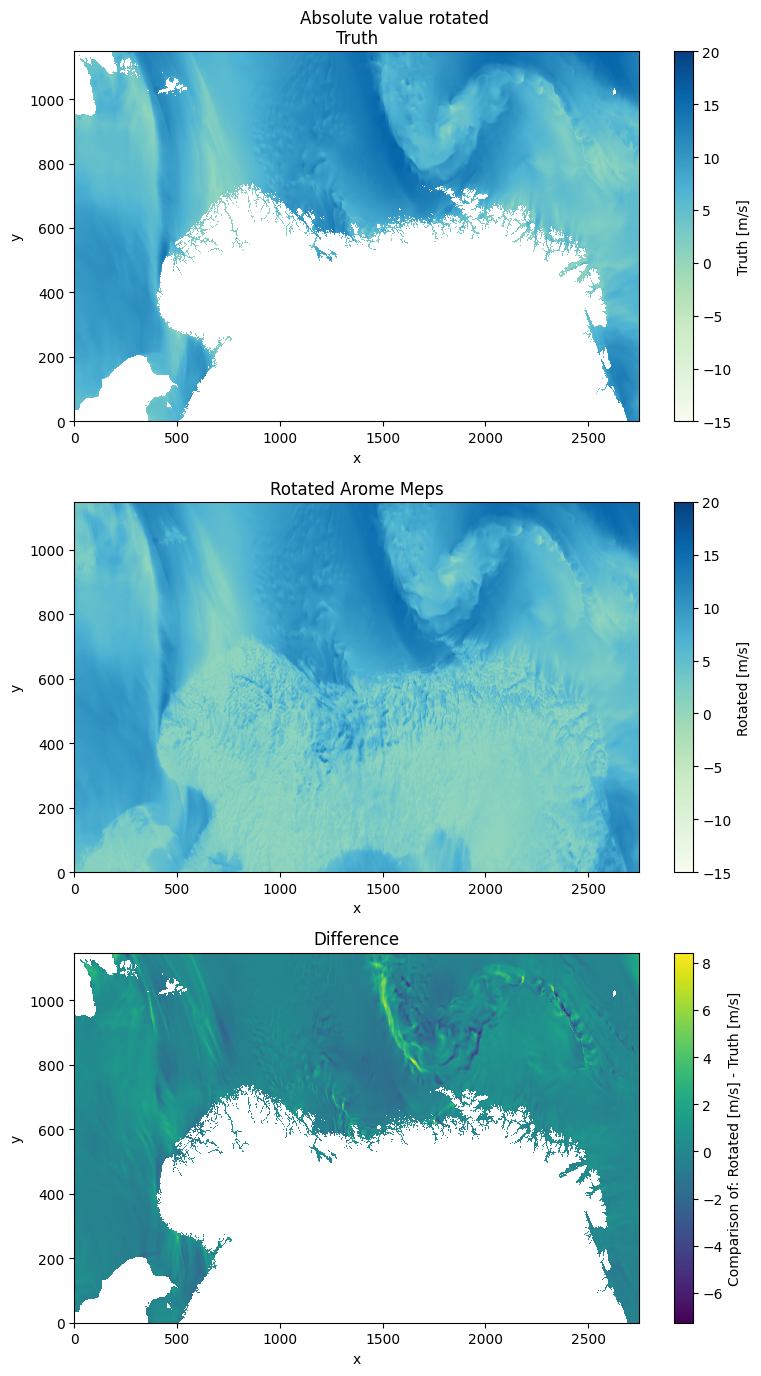

In [36]:
abs_val_rot = np.sqrt(urot**2 + vrot**2)    
plotting_output_compare(variable_1=abs_val_ideal, variable_2=abs_val_rot, title_1="Truth", title_2="Rotated Arome Meps", title_3="Difference", suptitle="Absolute value rotated", variable_1_name="Truth [m/s]", variable_2_name="Rotated [m/s]")

# **Checking the vector fields for randomly selected areas**

In [38]:
ds_ideal_2023_u_selarea = ds_ideal_2023["Uwind_eastward"]
ds_ideal_2023_v_selarea = ds_ideal_2023["Vwind_northward"]
lon = ds_ideal_2023_u_selarea["lon"]
lat = ds_ideal_2023_u_selarea["lat"]

In [48]:
ds_ideal_2023_n = xr.open_dataset(f'{ideal_file_path}/2023/05/norkyst800-20230501.nc').isel(time = 0, s_rho = -1, X = 23, Y = 213)
interp_2023_u_n = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Uwind.nc').isel(time=0, X = 23, Y=213)
interp_2023_v_n = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Vwind.nc').isel(time=0, X = 23, Y=213)

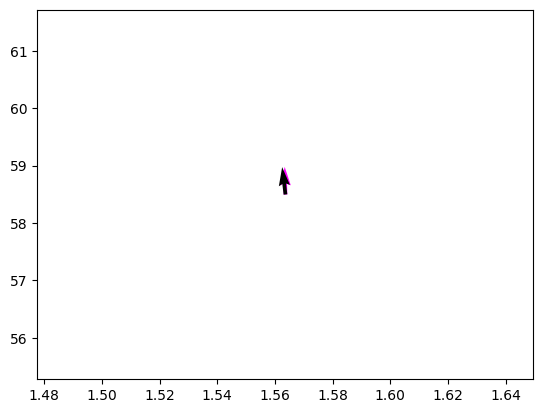

In [49]:
plt.quiver(lon,lat,ds_ideal_2023_n["Uwind_eastward"], ds_ideal_2023_n["Vwind_northward"], color = "magenta")
plt.quiver(lon,lat,interp_2023_u_n["Uwind"],interp_2023_v_n["Vwind"])

In [ ]:
ds_ideal_2023_slice = xr.open_dataset(f'{ideal_file_path}/2023/05/norkyst800-20230501.nc').isel(time = 0, s_rho = -1, X = slice(23,46), Y = slice(45,68))
interp_2023_u_slice = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Uwind.nc').isel(time=0, X = slice(23,46), Y = slice(45,68))
interp_2023_v_slice = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Vwind.nc').isel(time=0, X = slice(23,46), Y = slice(45,68))
#ds_ideal_2023_slice["Uwind_eastward"].values.__len__()
#interp_2023_u_slice["Uwind"].values.__len__()
#interp_2023_v_slice["Vwind"].values.__len__()

print(f'Ideal: Uw: {ds_ideal_2023_slice["Uwind_eastward"].shape}, Vw:{ds_ideal_2023_slice["Vwind_northward"].shape}, X: {ds_ideal_2023_slice.X.shape}, Y: {ds_ideal_2023_slice.Y.shape}')
X,Y = np.meshgrid(ds_ideal_2023_slice.X, ds_ideal_2023_slice.Y)

Ideal: Uw: (23, 23), Vw:(23, 23), X: (23,), Y: (23,)


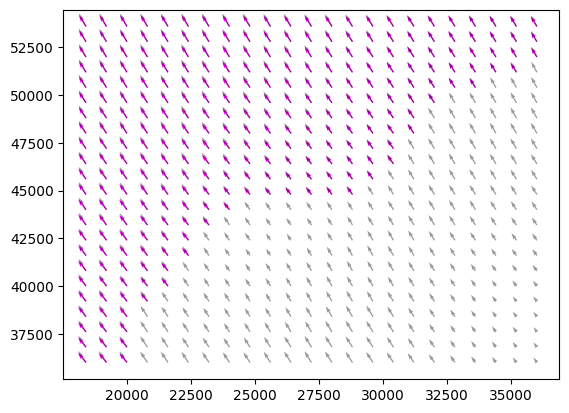

In [86]:
plt.quiver(X,Y,ds_ideal_2023_slice["Uwind_eastward"], ds_ideal_2023_slice["Vwind_northward"], color = "magenta")
plt.quiver(X,Y,interp_2023_u_slice["Uwind"], interp_2023_v_slice["Vwind"], color = "black", alpha = 0.4)

In [87]:

ds_ideal_2023_slice = xr.open_dataset(f'{ideal_file_path}/2023/05/norkyst800-20230501.nc').isel(time = 0, s_rho = -1, X = slice(213,243), Y = slice(527,557))
interp_2023_u_slice = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Uwind.nc').isel(time=0, X = slice(213,243), Y = slice(527,557))
interp_2023_v_slice = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Vwind.nc').isel(time=0, X = slice(213,243), Y = slice(527,557))
#ds_ideal_2023_slice["Uwind_eastward"].values.__len__()
#interp_2023_u_slice["Uwind"].values.__len__()
#interp_2023_v_slice["Vwind"].values.__len__()

print(f'Ideal: Uw: {ds_ideal_2023_slice["Uwind_eastward"].shape}, Vw:{ds_ideal_2023_slice["Vwind_northward"].shape}, X: {ds_ideal_2023_slice.X.shape}, Y: {ds_ideal_2023_slice.Y.shape}')
X,Y = np.meshgrid(ds_ideal_2023_slice.X, ds_ideal_2023_slice.Y)

Ideal: Uw: (30, 30), Vw:(30, 30), X: (30,), Y: (30,)


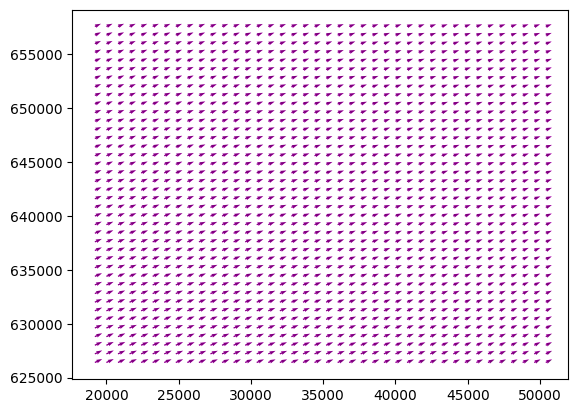

In [ ]:
plt.quiver(X,Y,ds_ideal_2023_slice["Uwind_eastward"], ds_ideal_2023_slice["Vwind_northward"], color = "magenta")
plt.quiver(X,Y,interp_2023_u_slice["Uwind"], interp_2023_v_slice["Vwind"], color = "black", alpha = 0.5)

There are some differences between the truth vectors (Norkyst 800 - color = Magenta) and the Arome Meps vectors (color = Black).

But the general direction of the vectors correspond quite well without the need of rotating the Arome Meps dataset.